# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML

from sklearn.preprocessing import normalize

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA

from sklearn.metrics import mean_squared_error

In [3]:
# data = pd.read_csv('Data/training_1.csv')
# data = data.drop(columns={'DATETIME'})

# data2 = pd.read_csv('Data/training_2.csv')
# data2.columns = data2.columns.str.replace(' ', '')
# data2 = data2.drop(columns={'DATETIME'})

# data3 = pd.read_csv('Data/test.csv')
# data3 = data3.drop(columns={'DATETIME'})

data = pd.read_csv('Data/training_1.csv')
data2 = pd.read_csv('Data/training_2.csv')
data3 = pd.read_csv('Data/test.csv')

data2.columns = data2.columns.str.replace(' ', '')

data['DATETIME'] = pd.to_datetime(data['DATETIME'], format='%d/%m/%y %H')
data2['DATETIME'] = pd.to_datetime(data2['DATETIME'], format='%d/%m/%y %H')
data3['DATETIME'] = pd.to_datetime(data3['DATETIME'], format='%d/%m/%y %H')

for col in data.columns:
    if col not in ['DATETIME', 'ATT_FLAG']:
        data[col] = data[col].astype('float')
        data2[col] = data2[col].astype('float')
        data3[col] = data3[col].astype('float')

train_data = data.drop(columns=['ATT_FLAG', 'DATETIME'])
test_data1 = data2.drop(columns=['ATT_FLAG', 'DATETIME'])
test_data2 = data3.drop(columns=['DATETIME'])

# for col in train_data.columns:
#     train_data[col] = train_data[col].astype('float')
#     test_data1[col] = test_data1[col].astype('float')
#     test_data2[col] = test_data2[col].astype('float')
    
data2.loc[data2['ATT_FLAG'] < 0, 'ATT_FLAG'] = 0
data3['ATT_FLAG'].fillna(0, inplace=True)


# Familiarization task – 1 A4 

Answer the following questions:
* What kinds of signals are there?
* Are the signals correlated? Do they show cyclic behavior?
* Is predicting the next value in a series easy or hard? Use any method from class.

Visualize these types, the presence or absence of correlation, and the performance of prediction.

TODOS:
* Little bit more about cyclic behaviour
* Draw conclusions from predictions

### What kinds of signals are there?

The data is categorized as follows:
* T Are the water tanks
    * L_Tx stands for the water level in the tanks (float)
* PU Are the pumps
    * F_PUx(x) stands for the flow through the pumt(float)
    * S_PUx(x) stands for the status of the pump (on (1) / off (0)) (binary)
* V is a valve
    * F_Vx stands for flow through the valve (float) 
    * S_Vx stands for the status of the valve (open (1) / closed (0)) (binary)
* J are junctions
    * P_Jxxx stands for the pressure in the junction (float)

* ATT_FLAG is the attack flag (normal (0) / attack (1) / unknown (-999))

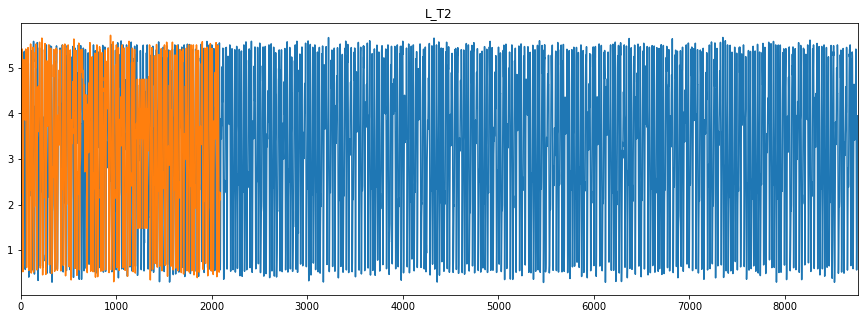

<Figure size 432x288 with 0 Axes>

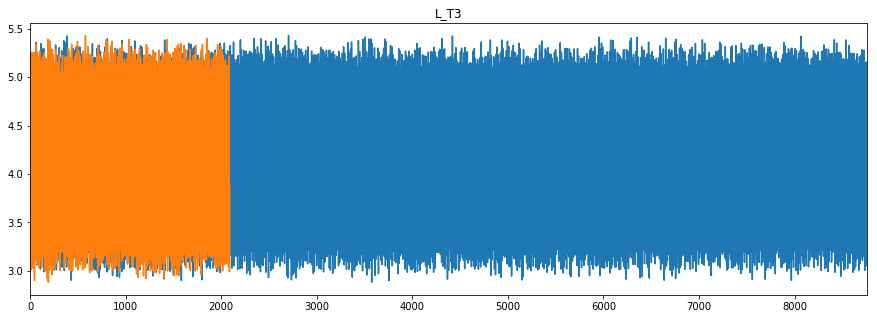

<Figure size 432x288 with 0 Axes>

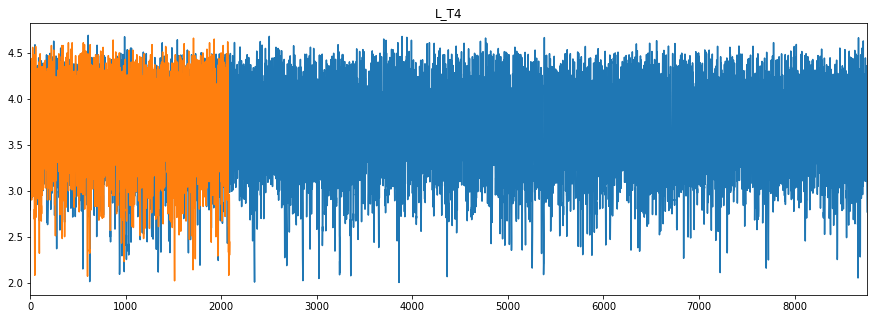

<Figure size 432x288 with 0 Axes>

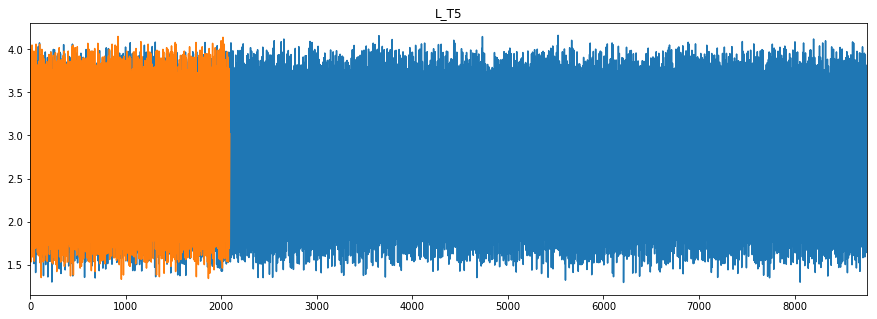

<Figure size 432x288 with 0 Axes>

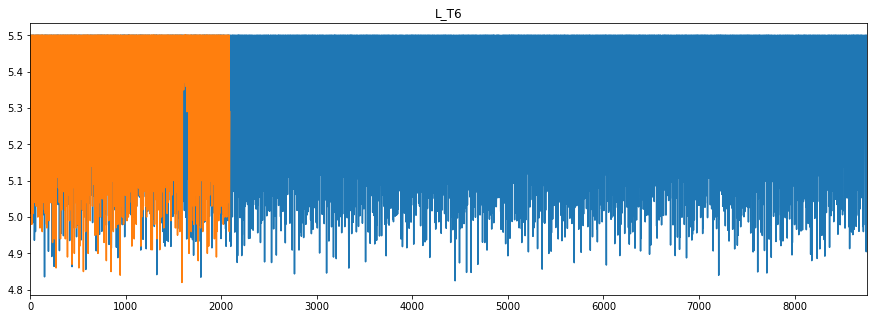

<Figure size 432x288 with 0 Axes>

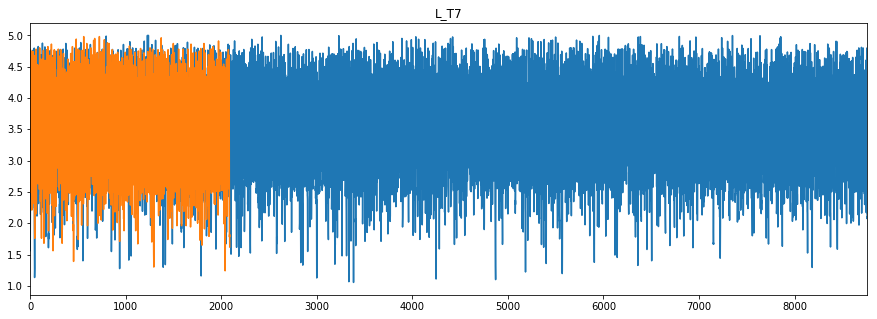

<Figure size 432x288 with 0 Axes>

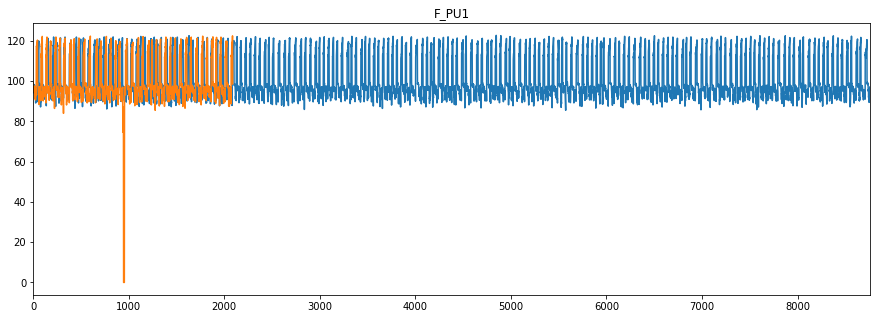

<Figure size 432x288 with 0 Axes>

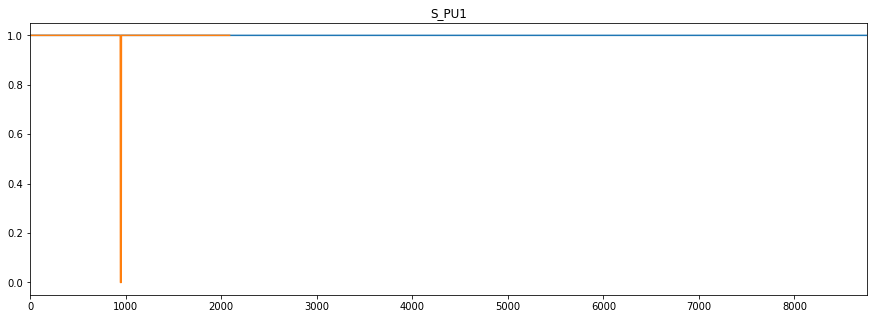

<Figure size 432x288 with 0 Axes>

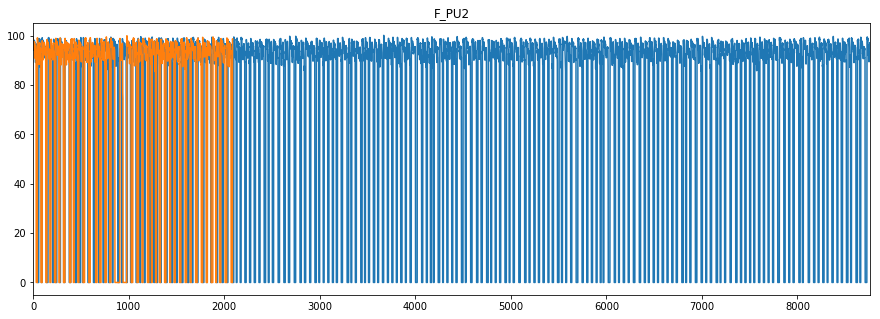

<Figure size 432x288 with 0 Axes>

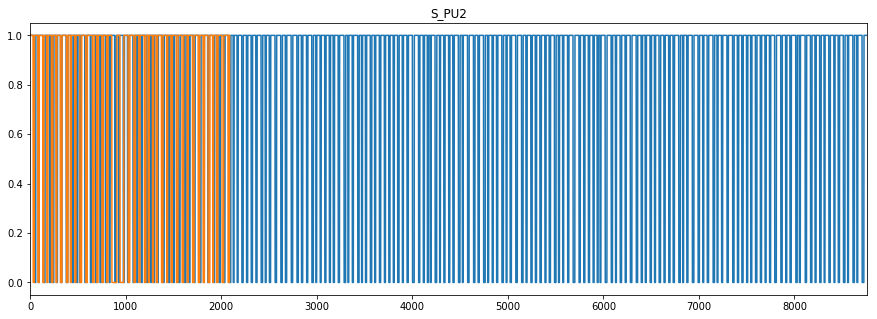

<Figure size 432x288 with 0 Axes>

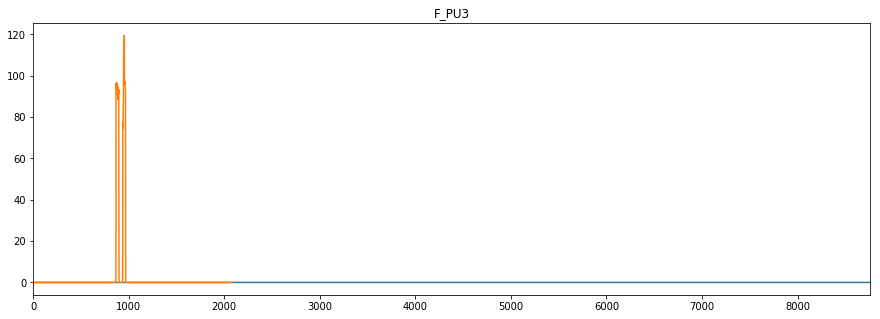

<Figure size 432x288 with 0 Axes>

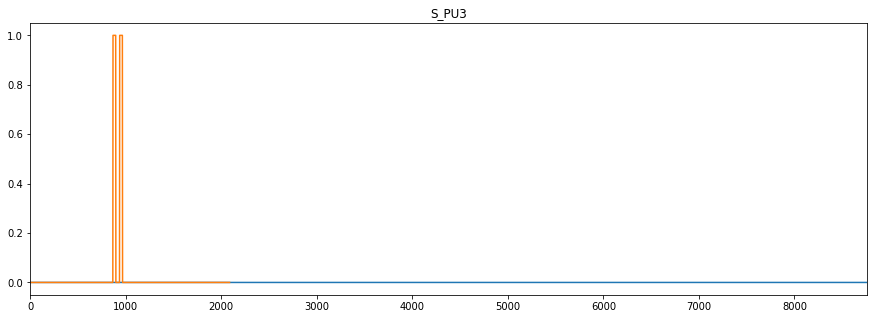

<Figure size 432x288 with 0 Axes>

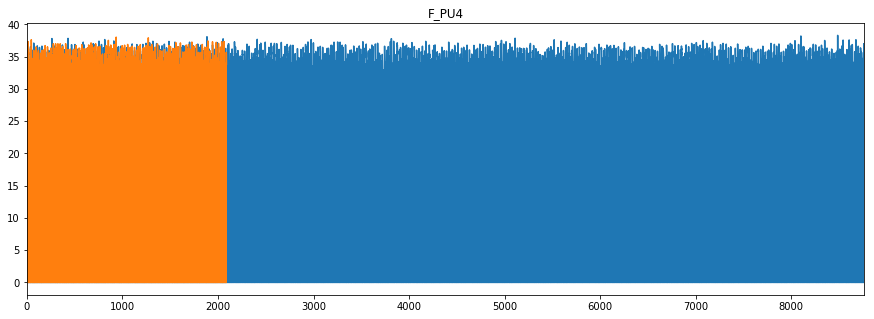

<Figure size 432x288 with 0 Axes>

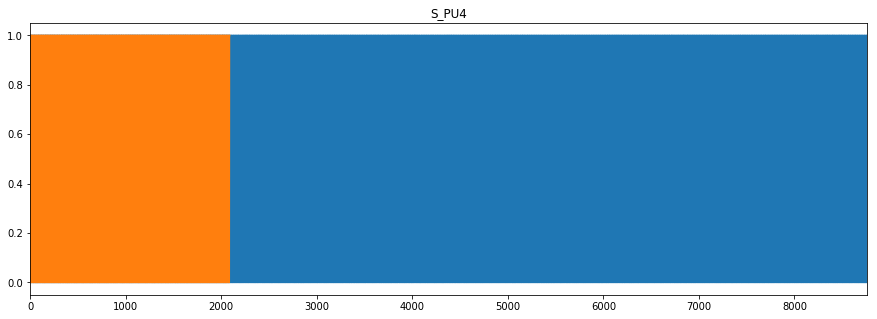

<Figure size 432x288 with 0 Axes>

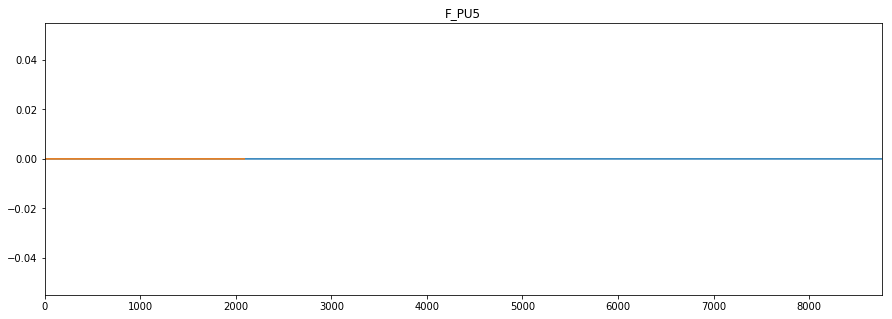

<Figure size 432x288 with 0 Axes>

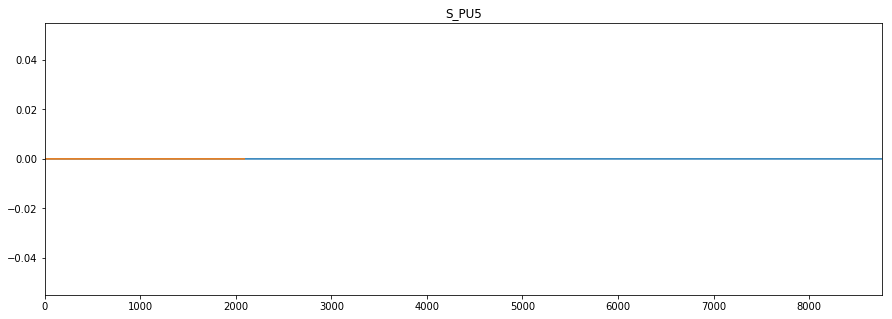

<Figure size 432x288 with 0 Axes>

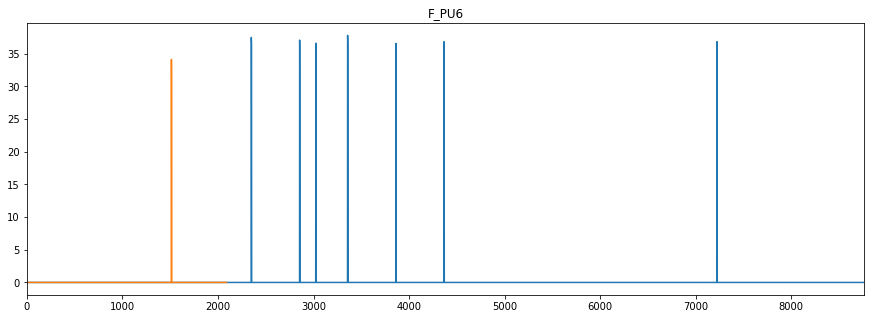

<Figure size 432x288 with 0 Axes>

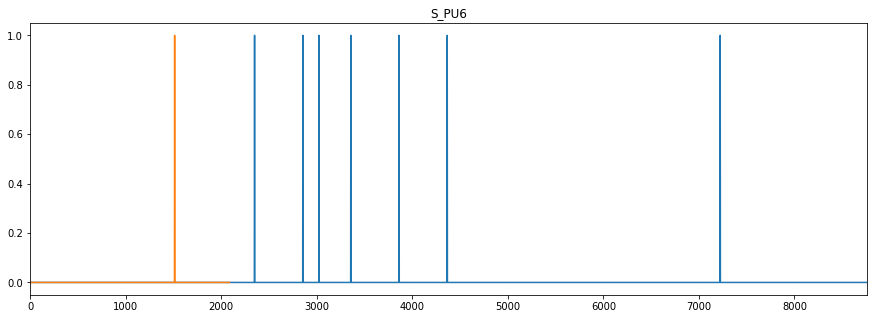

<Figure size 432x288 with 0 Axes>

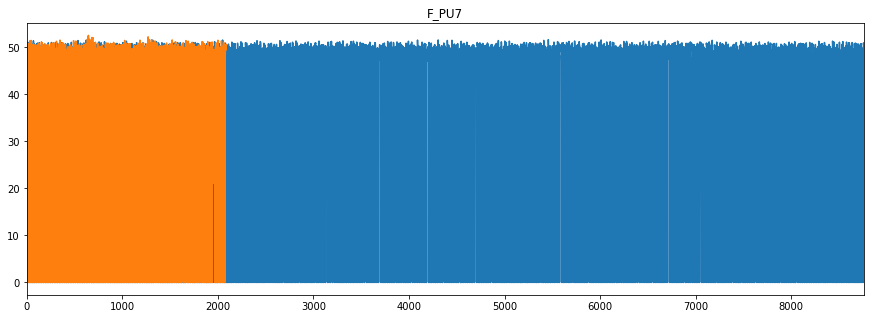

<Figure size 432x288 with 0 Axes>

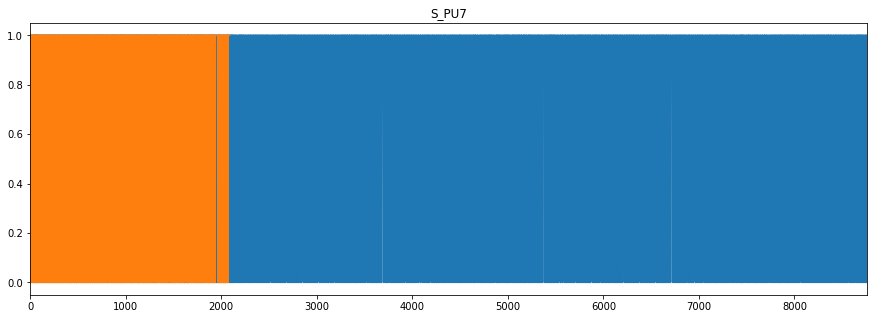

<Figure size 432x288 with 0 Axes>

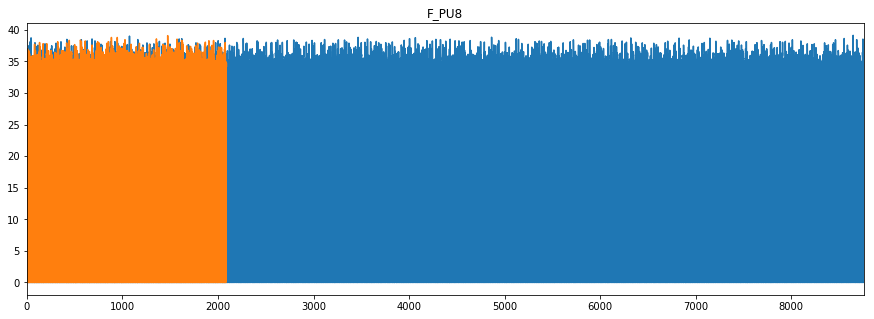

<Figure size 432x288 with 0 Axes>

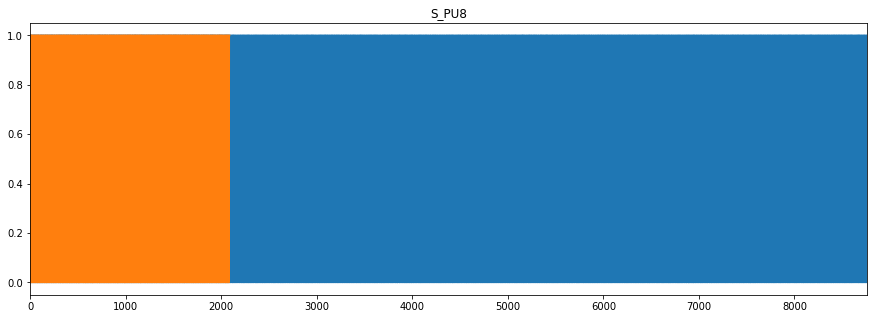

<Figure size 432x288 with 0 Axes>

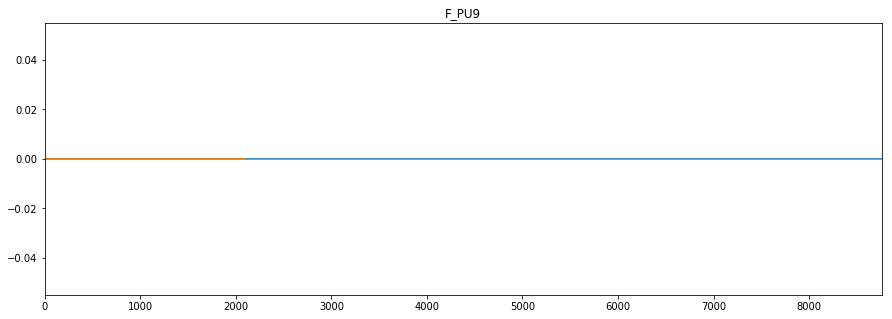

<Figure size 432x288 with 0 Axes>

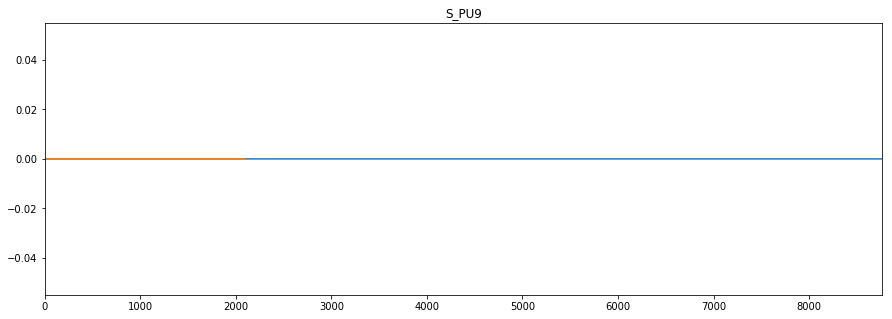

<Figure size 432x288 with 0 Axes>

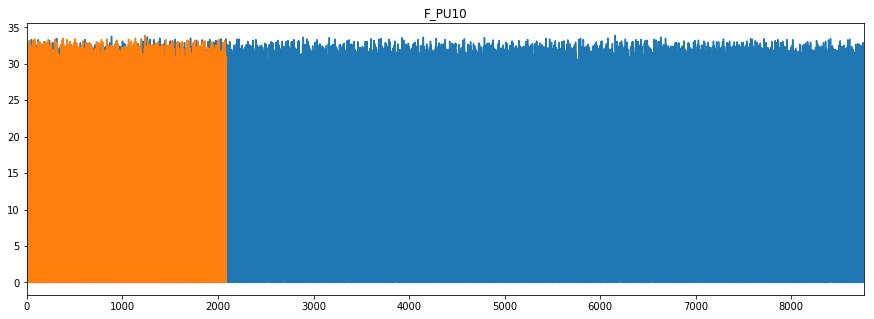

<Figure size 432x288 with 0 Axes>

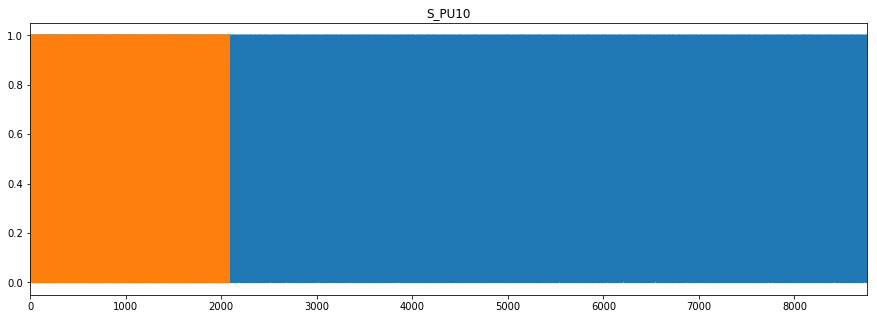

<Figure size 432x288 with 0 Axes>

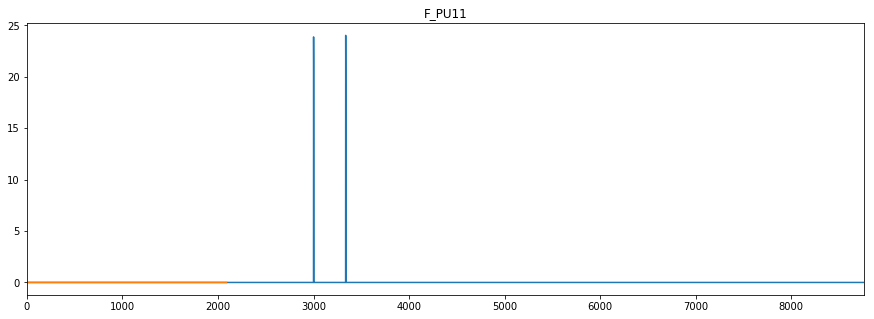

<Figure size 432x288 with 0 Axes>

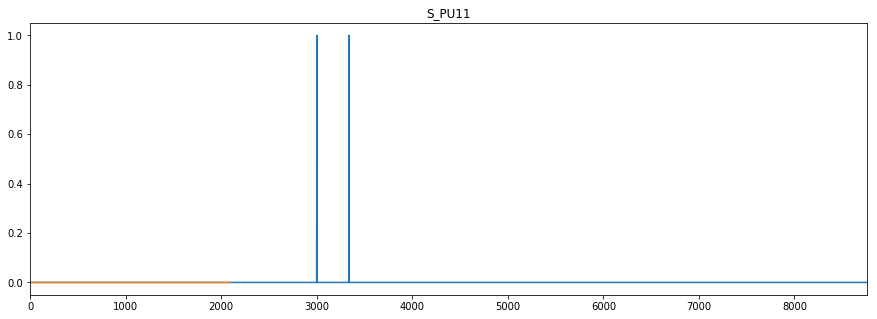

<Figure size 432x288 with 0 Axes>

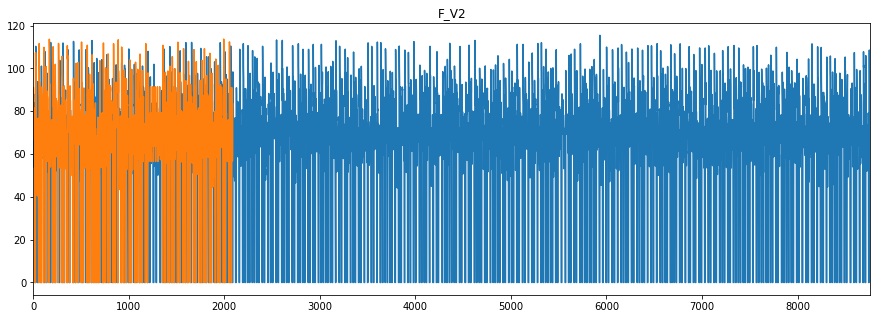

<Figure size 432x288 with 0 Axes>

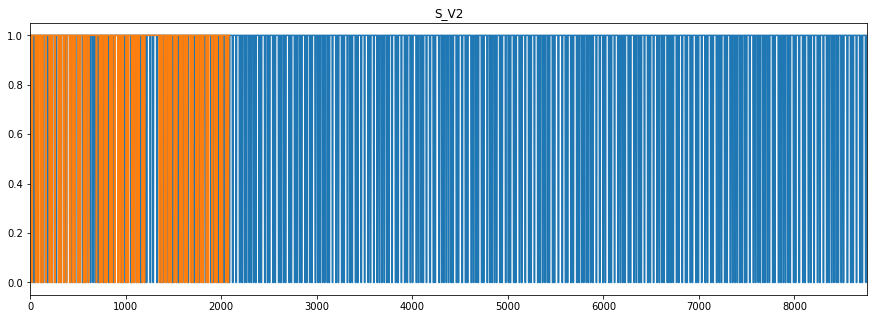

<Figure size 432x288 with 0 Axes>

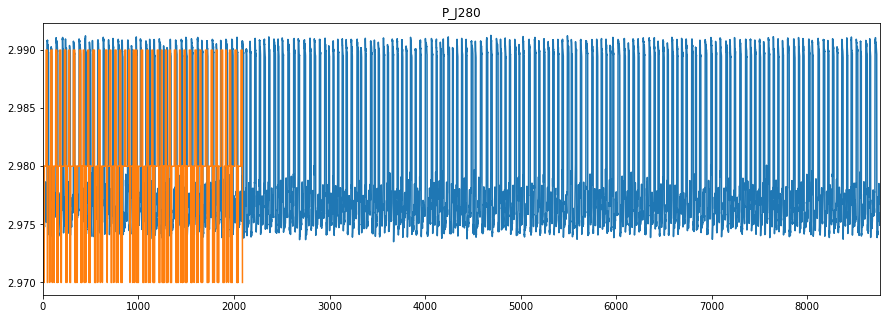

<Figure size 432x288 with 0 Axes>

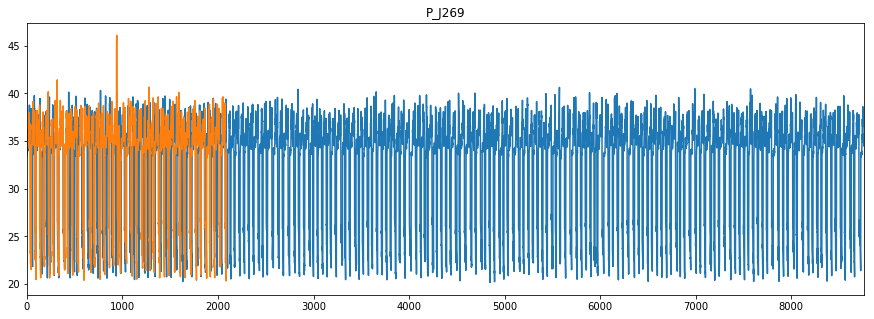

<Figure size 432x288 with 0 Axes>

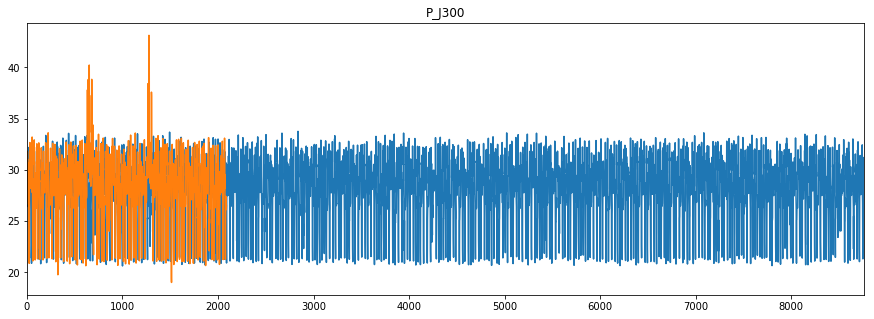

<Figure size 432x288 with 0 Axes>

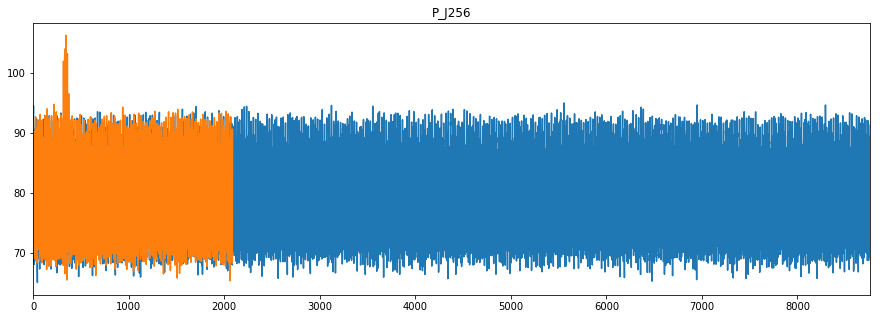

<Figure size 432x288 with 0 Axes>

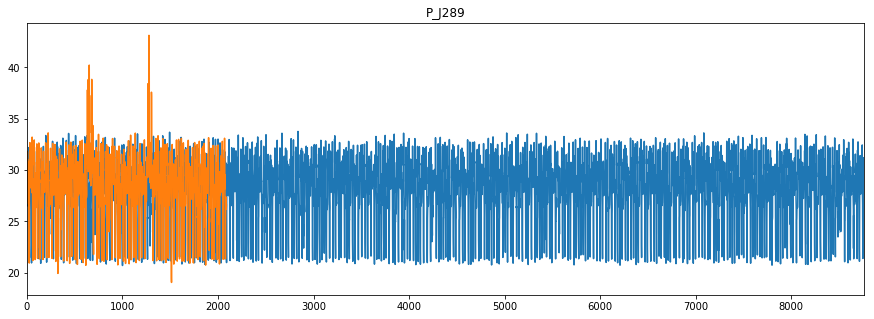

<Figure size 432x288 with 0 Axes>

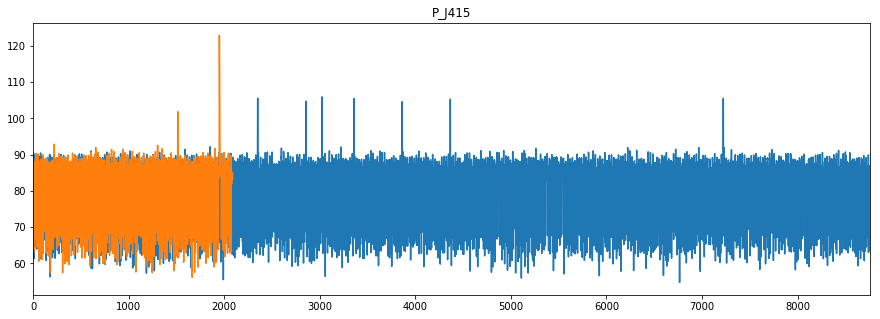

<Figure size 432x288 with 0 Axes>

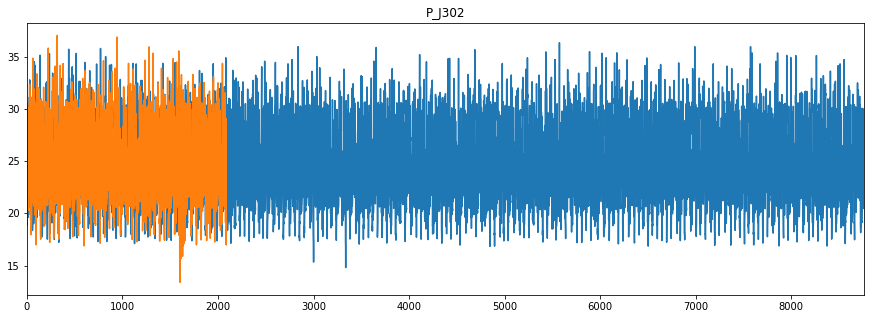

<Figure size 432x288 with 0 Axes>

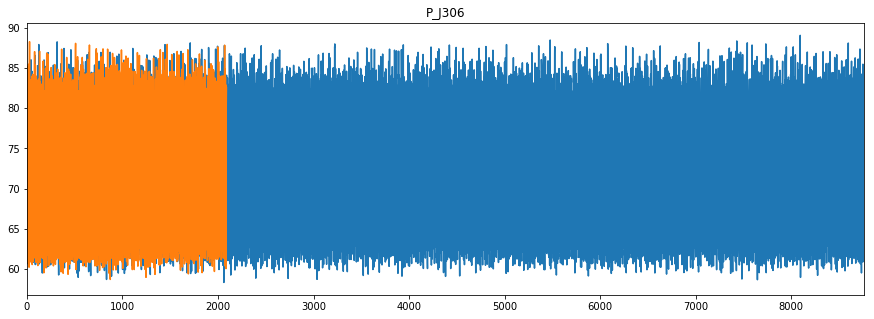

<Figure size 432x288 with 0 Axes>

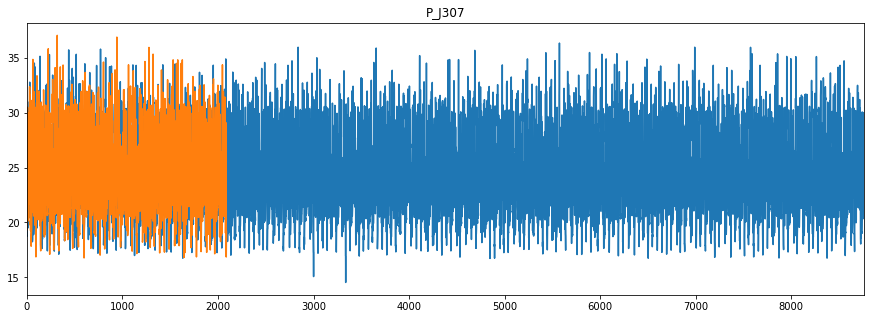

<Figure size 432x288 with 0 Axes>

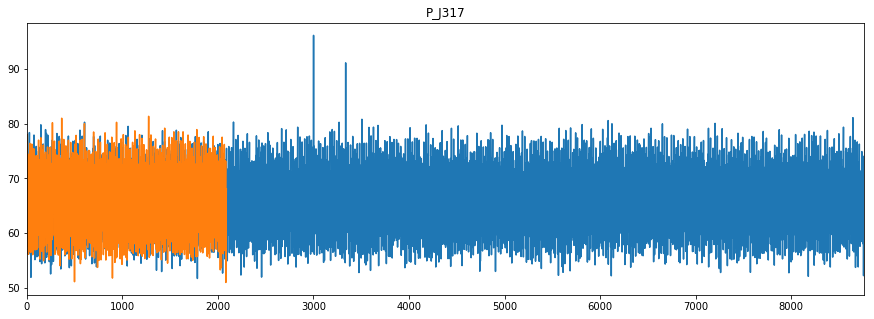

<Figure size 432x288 with 0 Axes>

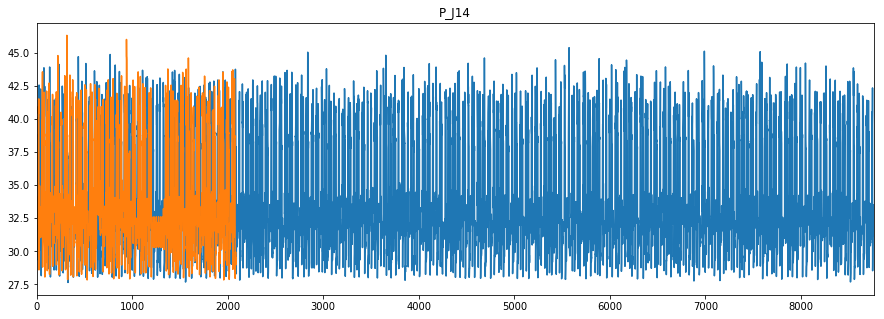

<Figure size 432x288 with 0 Axes>

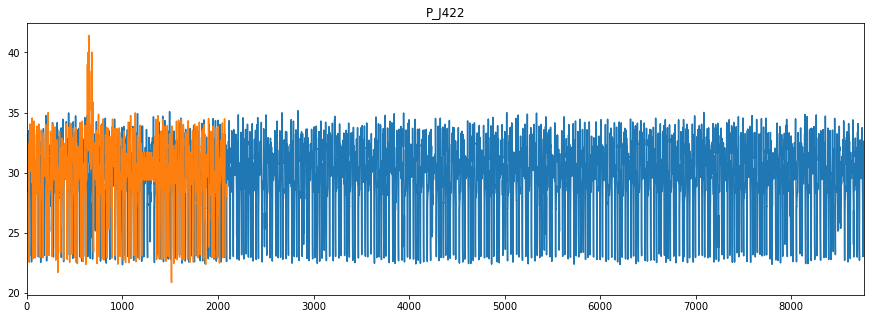

<Figure size 432x288 with 0 Axes>

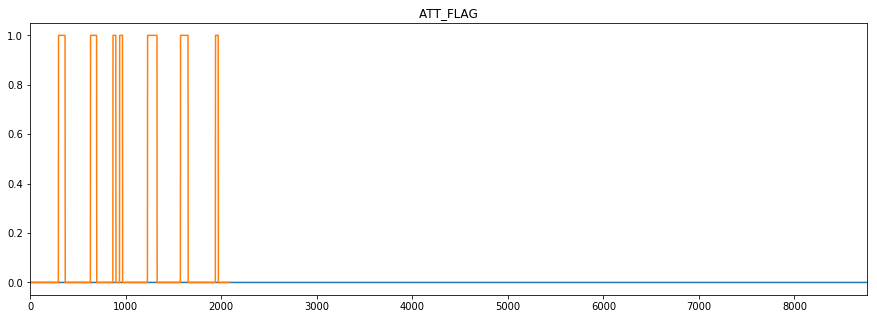

<Figure size 432x288 with 0 Axes>

In [22]:
for i, cl in enumerate(data.columns[1:]):
    plt.figure(figsize=(15,5))
    plt.title(cl)
    data[cl].plot()
    if cl in data3:
        data3[cl].plot()
    plt.show()
    plt.clf()

### Are the signals correlated? Do they show cyclic behavior?

As one can see in the correlation heatmap below there is some data correlated

The interesting ones for now are the correlations between actuators and sensors (not from the same machine). Taking the lowest and highest correlations <-1:-0.75> and <0.75:1> from the subset described gives some interesting plots. Although not all the time deltas are equal there is a clear cycle visible between waterlevels/flows/pressure and when actuators are activated

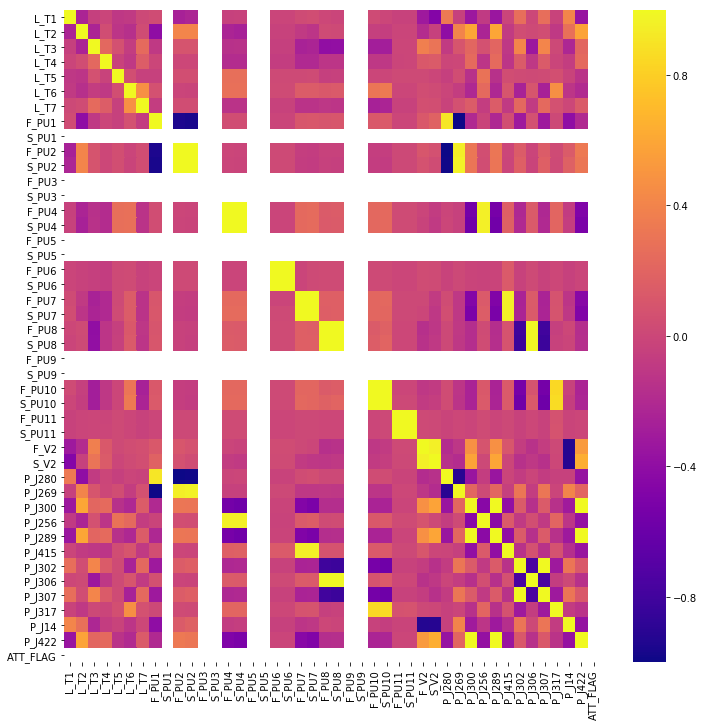

In [4]:
f, ax = plt.subplots(figsize=(12, 12))
corr = data.corr()
sns.heatmap(data.corr(), cmap='plasma')
plt.show()

In [5]:
cr_series = corr.unstack().sort_values(ascending=False).drop_duplicates().dropna()
cr = pd.DataFrame(cr_series)
cr['high'] = cr_series.between(-0.75, 0.75, inclusive=True)
cr = cr[cr['high']==False].drop('high', axis='columns').reset_index().set_axis(['x', 'y', 'correlation'], axis='columns', inplace=False)

# Filter correlations with itself
cr = cr[cr['x'] != cr['y']]

# Filter correlations between status and flow of same machine
cr = cr[cr['x'].str.split('_', expand=True)[1] != cr['y'].str.split('_', expand=True)[1]]

# Most interesting are the correlatiosn between sensors and actuators
cr = cr[(cr['x'].str.split('_', expand=True)[0] =='S') | (cr['y'].str.split('_', expand=True)[0]=='S')]

display(HTML(cr.to_html()))


,x,y,correlation
13,P_J306,S_PU8,0.989426
14,P_J269,S_PU2,0.962877
15,S_PU7,P_J415,0.960707
16,S_PU4,P_J256,0.958924
22,P_J317,S_PU10,0.861843
28,S_PU8,P_J307,-0.820805
29,S_PU8,P_J302,-0.823764
31,S_V2,P_J14,-0.919642
34,F_PU1,S_PU2,-0.961986
35,P_J280,S_PU2,-0.986258


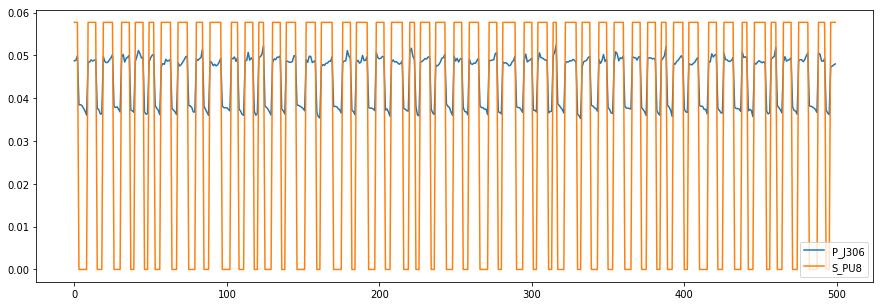

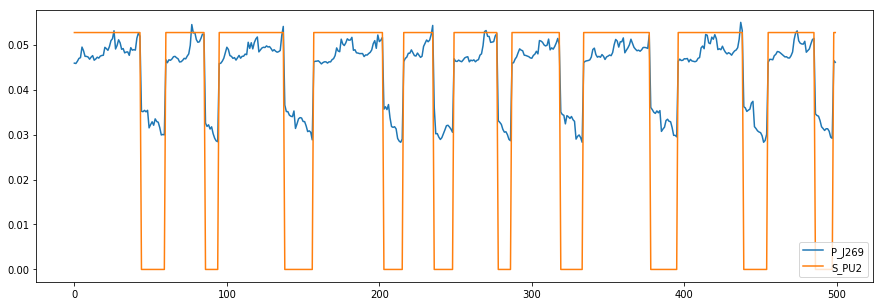

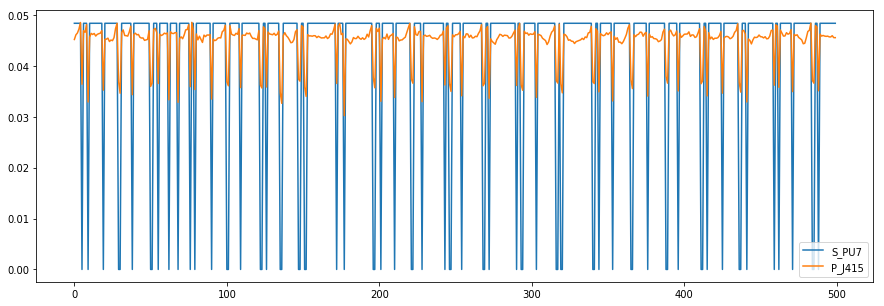

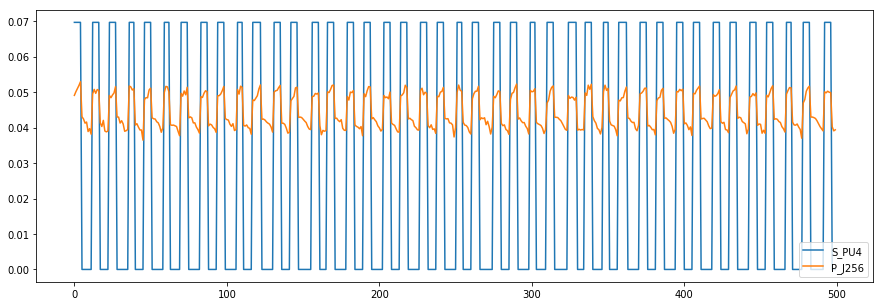

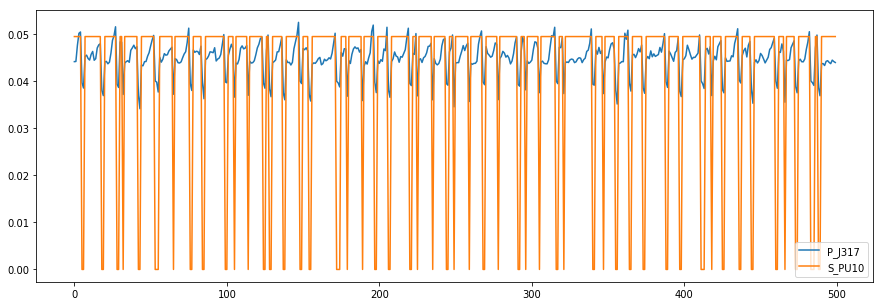

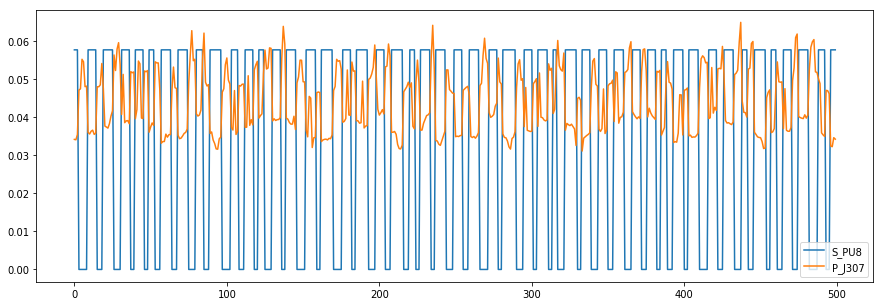

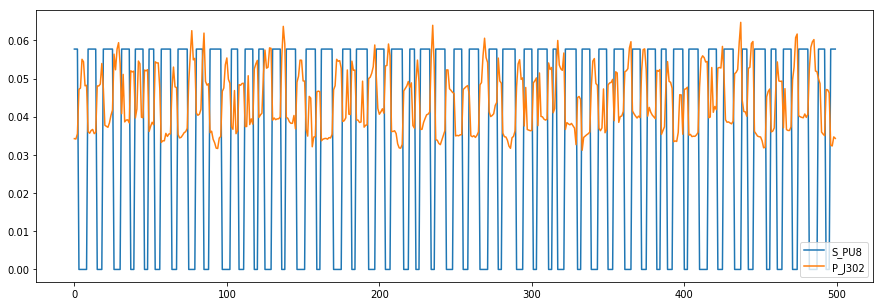

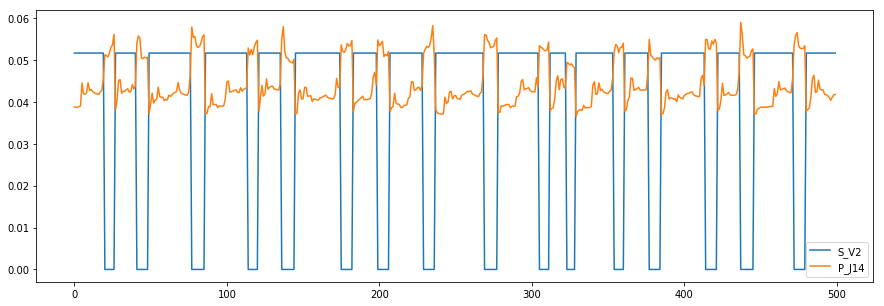

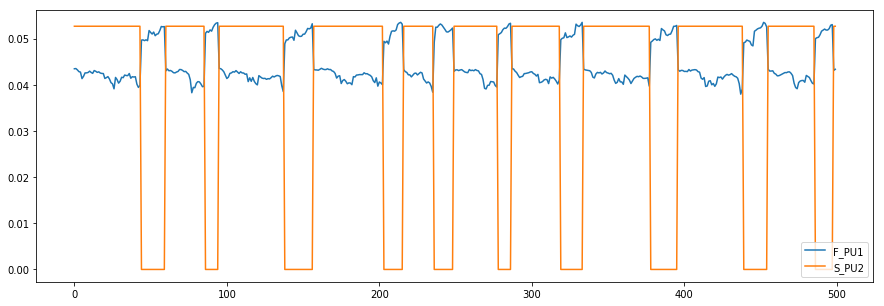

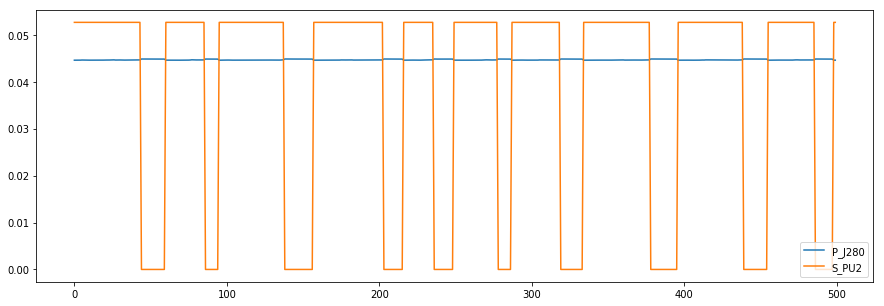

In [6]:
for row in cr.itertuples():
    plt.figure(figsize=(15,5))
    plt.plot(normalize(data[row[1]][:500].values.reshape(1, -1)).reshape(-1, 1), label=row[1])
    plt.plot(normalize(data[row[2]][:500].values.reshape(1, -1)).reshape(-1, 1), label=row[2])
    plt.legend(loc = 'lower right')
    plt.show()
#     plt.clf()

### Is predicting the next value in a series easy or hard? Use any method from class.

Using Auto regressive (AR)

// https://machinelearningmastery.com/make-predictions-time-series-forecasting-python/

Test MSE: 21.223


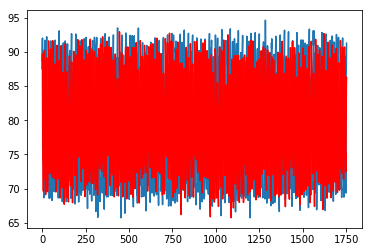

In [7]:
def predict(coef, history):
    #initialize on constant
    yhat = coef[0]
    # sum( phi(i) * X(t-1)) for i=1 till i=p
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat

signal = 'P_J256'
train_size = int(len(data)*0.8)
train_data = data[signal][0:train_size]
test_data = data[signal][train_size:].reset_index(drop='true')
predictions = list()

# Order for AR
p=10
#Create and train model
model = AR(train_data)
model_fit = model.fit(p)
# Get coefficients (+ constant)
coef = model_fit.params
# Retreive last p points
history = train_data[-p:].to_list()

# Predict same amount as values as availale in test set
for t in range(len(test_data)):
    # predict next value and add to list
    yhat = predict(coef, history)
    predictions.append(yhat)
    
    # add original point to history for next prediction
    obs = test_data[t]
    history.append(obs)
    
error = mean_squared_error(test_data, predictions)
print('Test MSE: %.3f' % error)

# plot
plt.plot(test_data)
plt.plot(predictions, color='red')
plt.show()

# ARMA task 

Learn an autoregressive moving average model for at least 5 individual sensors (pick them in a sensible way!). Most statistical packages (statsmodels in Python) contain standard algorithm for fitting these models from training data. Use autocorrelation plots in order to identify the order of the ARMA models. The parameters can be determined using Akaike’s Information Criterion (AIC) or another model selection method. Note that there exists a wide range of ARMA variants; you only have to use the basic model. 

Decide how to set the detection threshold sensibly. Study some of the anomalies detected anomalies. What kind of anomalies can you detect using ARMA models? Which sensors can be modeled effectively using ARMA?

TODOS:
* Look at picking sensor data (now based on attack sheet)
* use autocorrelation to indetify order
* determine useing AIC
* Decide on threshold for attack
* write about this assignment
    

In [8]:
#  http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016#ARMA

def predict(ar_coef, history, ma_coef, residuals):
    # AR: sum( phi(i) * X(t-1)) for i=1 till i=p
    # MA: sum( phi(i) * eps(t-1)) for i=1 till i=q (esp is residual error noise)
    yhat = 0
    for i in range(0, len(ar_coef)):
        yhat += ar_coef[i] * history[-i-1]
        
    for i in range(0, len(ma_coef)):
        yhat += ma_coef[i] * residuals[-i-1]
    return yhat

# p = order of AR     q = order of MA
def arma_predict(train_data, test_data, attack_data, feature_name, p=2, q=2, plot_start=-1, plot_end=-1):
    model = ARMA(train_data, (p,q))
    model_fit = model.fit()
    ar_coef = model_fit.arparams
    ma_coef = model_fit.maparams

    history = train_data[-p:].to_list()
    residuals = model_fit.resid[-q:].to_list()
    predictions = list()

    # Predict same amount as values as availale in test set
    for i in range(len(data2)):
        # predict next value and add to list
        yhat = predict(ar_coef, history, ma_coef, residuals)
        predictions.append(yhat)

        # add original point to history for next prediction
        obs = test_data[i]
        history.append(obs)
        residuals.append(obs-yhat)

    #  remove initializations residuals
    residuals = residuals[q:]

    start = plot_start if plot_start>-1 else 0
    end = plot_end if plot_end> -1 and plot_end > plot_start else len(residuals)

    # corrfect for the avarage of the residuals. Since this is the error between original and prediction we want to shift it for half
    residuals = pd.DataFrame(residuals-0.5*np.mean(residuals))

    # plot
    plt.figure(figsize=(15,5))
    plt.plot(test_data[start:end], color='blue')
    plt.plot(residuals[start:end], color='green')
    plt.plot(attack_data[start:end], color='red')
    axes=plt.gca()
    axes.set_ylim((-100, 150))
    plt.legend(['original signal', 'predicted signal', 'attack flag'])
    plt.title('ARMA prediction attack on: '+feature_name)
    plt.show()

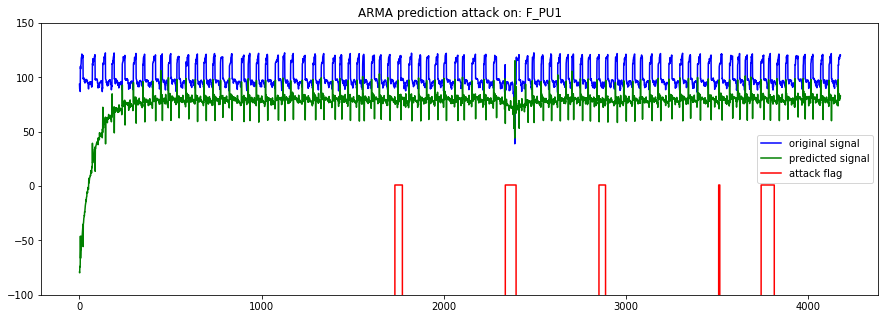

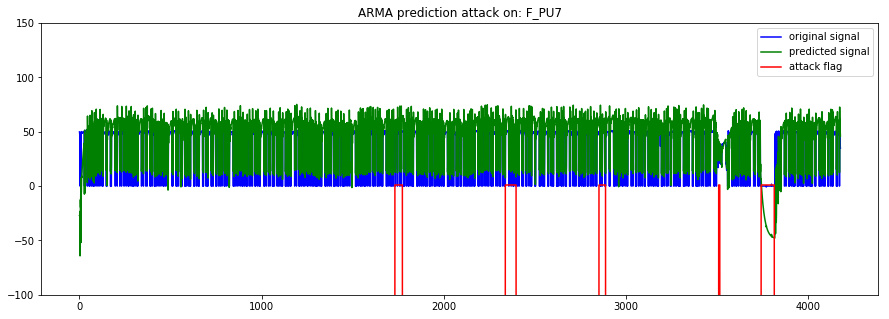

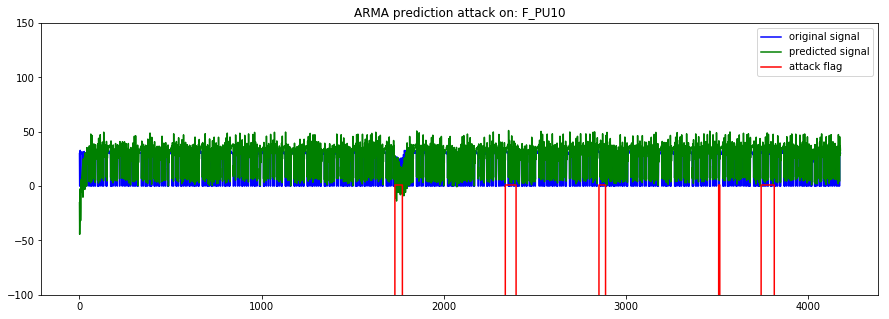

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


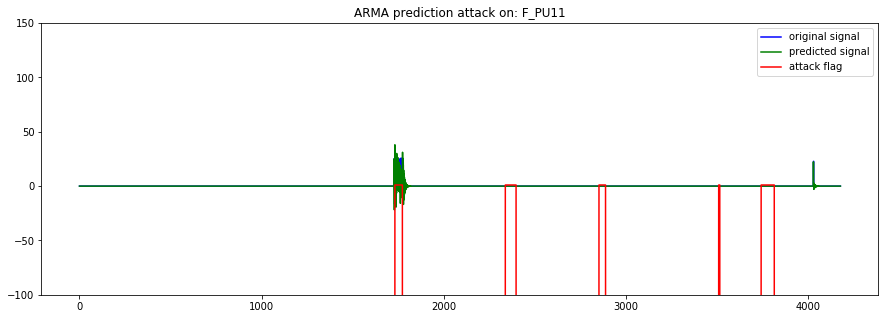

In [9]:
signal = ['F_PU1', 'F_PU7', 'F_PU10', 'F_PU11']

for sig in signal:
    arma_predict(data[sig], data2[sig], data2['ATT_FLAG'], sig, p=3, q=3)

# Discrete models task

Discretize the sensor data using any of the methods discussed in class. Explain why you choose this method and why the obtained discretization makes sense. Visualize the discretization. 

Apply any of the sequential data mining methods (N-grams, Sequence alignment with kNN, …) to sliding windows with a length of your choosing in order to find anomalies. Whenever an observed Ngram’s probability is too small, or the sequential data is too distant from any training sequence, raise an alarm. Set your thresholds sensibly. What kind of anomalies can you detect using the sequential model? Which sensors can be modeled effectively?

### Possible options for discretization:
- SAX (Symbolic Aggregate approXimation) 
SAX makes sense because it keeps the interesting information from the data: water level high/low/medium, and the flow of a certain pump is high/low/medium.
- Percentiles (.2 top, .02 bottom, .6 middle?)
Percentiles does not make sense, because most of the data will be in top or bottom, boundaries would not make sense.
- Change point detection
CPD could be interesting for detecting a change point, which does not correlate with a pump/valve being turned on. Maybe we are not interested in how the level changes, but on that it is low. On the other hand, it does say a lot if it goes steeply down and stays like that for some time. But a SAX would then be more logic, because that is the real information we are using. It is also the case that it can go up/down all the time, but in effect just be very low. Then the very low is probably more interesting than it going down. Could be nice for making a state machine (e.g. from slight up to quickly down, etc)

Choices for discretization: Discretize every individual data point, an sequence of points, whit ot without gaps?
Behaviour to model: exact values, trends, differences, fluctuations? Do what makes sense and leads to interpretable outcomes. When uncertain: try different possibilities

### Possible options for modeling:
- Bayesian Network Distribution
- State machine
- Markov chains
- N-grams (markov chain based on sliding windows), needs to be combined with smoothing methods


In [19]:
from tslearn.piecewise import SymbolicAggregateApproximation
from sklearn.preprocessing import StandardScaler
import pprint
import math


VALUE_FOR_ANOMALITY_DETECTED = 1
VALUE_FOR_NORMALITY_DETECTED = 0
MINIMAL_VALUE_FOR_ATTACK = 0.99


def create_markov_chain_from_ngram(levels, attack_data, n_elements):    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    attacks = zip(levels, attack_data)
    levels_to_use = []
    # Do not use the attacks in determining normal behaviour.
    for level, attack_value in attacks:
        if attack_value >= MINIMAL_VALUE_FOR_ATTACK:
            # Do not take into account attacks when training
            levels_to_use.append(None)
        else:
            levels_to_use.append(level)
            
    ngrams = list(zip(*[levels_to_use[i:] for i in range(n_elements)]))
    markov_chain = {}
    for ngram in ngrams:
        if None not in ngram:
            last_element = ngram[-1]
            ngram_base = ngram[:-1]
            if ngram_base not in markov_chain:
                markov_chain.update({ngram_base: {}})
            known_transitions = markov_chain[ngram_base]
            if last_element not in known_transitions:
                known_transitions.update({last_element: 1})
            else:
                known_transitions[last_element] += 1
    return markov_chain


def classify_using_markov_chains(sax_training, attacks_in_training, sax_test, symbols, treshold, n_elements):
    markov_chain = create_markov_chain_from_ngram(sax_training, attacks_in_training, n_elements)
    detected_list = []
    for i in range(len(sax_test)):
        if i >= len(sax_test) - n_elements:
            # Take the last n_elements values into account if 
            # we are at the end
            sequence = sax_test[-n_elements:]
        else:
            sequence = sax_test[i:i+n_elements]
        
        base = tuple(sequence[:-1])
        head = sequence[-1]
        
        if base not in markov_chain:
            markov_chain.update({base: {}})
        last_elements = markov_chain[base]
        
        # Apply smoothing for unknown elements
        if head not in last_elements:
            last_elements.update({head: 1})
        base_occurences = sum(last_elements.values())
        occurences = last_elements[head]
        sequence_probability = occurences / base_occurences
        if sequence_probability < treshold or math.isclose(sequence_probability, treshold):        
            detected_list.append(VALUE_FOR_ANOMALITY_DETECTED)
        else:
            detected_list.append(VALUE_FOR_NORMALITY_DETECTED)
    return detected_list


def get_sax_data(training_data, test_data, alphabet_size):
    # Scale data
    scaler = StandardScaler()
    preprocessed_training_data = training_data.values.reshape(-1,1)
    preprocessed_test_data = test_data.values.reshape(-1,1)
    scaled_training_data = scaler.fit_transform(preprocessed_training_data).ravel()
    # Only transform is called, because we want the same scale as the training data
    scaled_test_data = scaler.transform(preprocessed_test_data).ravel()
    
    #Perform SAX
    sax = SymbolicAggregateApproximation(n_segments=len(training_data), alphabet_size_avg=alphabet_size)
    # Compute SAX representations
    fit = sax.fit(scaled_training_data)
    transformed_training = fit.transform(scaled_training_data)
    # Compute time series corresponding to given SAX representations.
    ts_train = fit.inverse_transform(transformed_training)[0].ravel()
    
    # We cannot use the previous SAX, as then the creation of the alphabe is influenced by the test set 
    sax = SymbolicAggregateApproximation(n_segments=len(test_data), alphabet_size_avg=alphabet_size) 
    transformed_test = sax.fit_transform(scaled_test_data)    
    ts_test = sax.inverse_transform(transformed_test)[0].ravel()
    return ts_train, ts_test


def discretization(training_set, test_set, features, alphabet_size, treshold, n_elements_ngram, pp_treshold):
    attacks_in_training = training_set['ATT_FLAG']
    real_attacks = test_set['ATT_FLAG']
    
    predictions = {}
    for feature in features: 
        # Just to be sure. We do not want to train on these columns.
        if feature in ['DATETIME', 'ATT_FLAG']:
            continue
            
#         if feature.startswith("L_T"):
#             continue 
#         if feature.startswith("S_PU"):
#             continue
#         if feature.startswith("F_PU"):
#             continue
        if feature.startswith("S_V"):
            continue
        if feature.startswith("F_V"):
            continue
#         if feature.startswith("P_J"):
#             continue
    
        # Calculate the Symbolic Aggregate approXimation
        sax_training, sax_test = get_sax_data(training_set[feature], test_set[feature], alphabet_size) 
        symbols_training = set(sax_training)
        symbols_test = set(sax_test)
        symbols = symbols_training.union(symbols_test)
        # Just to be sure
        if len(symbols) > alphabet_size:
            raise NotImplementedError("Too many symbols!")
        
        predicted_attacks = classify_using_markov_chains(sax_training, attacks_in_training, sax_test, symbols, 
                                                         treshold, n_elements_ngram)
        predictions.update({feature: predicted_attacks})
        
        # Some configuration for the plots
#         plt.figure(figsize=(15,5))
#         plt.plot(real_attacks,'r')
#         plt.plot(predicted_attacks, 'b-')
# #         plt.plot(sax_training, 'b-')
# #         plt.plot(sax_test, 'r-')

#         plot_title = f"{feature}, {alphabet_size} symbols, treshold {treshold}, ngram size {n_elements_ngram}"
#         plt.legend(['Real Attacks', 'Predicted Attacks'])
#         plt.title(plot_title)
# #             plt.savefig(plot_title)
#         plt.show()
    
    attacks_predicted = list(predictions.values())
    prediction = attacks_predicted[0]
    if len(features) > 1:
        for p in attacks_predicted[1:]:
            for i, e in enumerate(p):
                if e == VALUE_FOR_ANOMALITY_DETECTED:
                    prediction[i] += VALUE_FOR_ANOMALITY_DETECTED
                    
    combined = [1 if e >= pp_treshold else 0 for e in prediction]
    results = results_of_predictions(predictions, real_attacks, combined, pp_treshold)
    pprint.pprint(results)
    
    plt.figure(figsize=(15,5))
    plt.plot(real_attacks,'r')
    plt.plot(combined, 'b-')
    plot_title = f"SAX, {alphabet_size} symbols, treshold {treshold}, ngram size {n_elements_ngram}"
    plt.legend(['Real Attacks', 'Predicted Attacks'])
    plt.title(plot_title)
#     plt.savefig(plot_title)
    plt.show()
    

def results_of_predictions(predictions, real_attacks, combined, pp_treshold):
    results = {'ALL': {'FP': 0, 'DETECTED': 0}}
    grouped = {'ALL': combined}
    att_ranges = attack_ranges(real_attacks)
    prediction_set = set()
    for feature, prediction in predictions.items():
        if feature.startswith("L_T"):
            sensor_name = "L_T"
        if feature.startswith("S_PU"):
            sensor_name = "S_PU"
        if feature.startswith("F_PU"):
            sensor_name = "F_PU"
        if feature.startswith("S_V"):
            sensor_name = "S_V"
        if feature.startswith("F_V"):
            sensor_name = "F_V"
        if feature.startswith("P_J"):
            sensor_name = "P_J"
            
        if sensor_name not in results:
            results.update({sensor_name: {'FP': 0, 'DETECTED': 0}})
            grouped.update({sensor_name: prediction})
            
        grouped_prediction = grouped[sensor_name]
        for i, p in enumerate(prediction):
            prediction_set.add(p)
            if p == 1:
                grouped_prediction[i] = 1
                
#     c = 0
#     for i, p in enumerate(grouped['ALL']):
#         e = 0
#         if p >= pp_treshold:
#             c += 1
#             e = 1
#         grouped['ALL'][i] = e
#     print(c)
    for sensor_name, prediction in grouped.items():
        for i, p in enumerate(prediction):
            r = real_attacks[i]
            if r == 0 and p == 1:
                results[sensor_name]['FP'] += 1
        for (start, end) in att_ranges:
            prediction_range = prediction[start:end]
            if 1 in prediction_range:
                results[sensor_name]['DETECTED'] += 1
    return results 
    
    
def attack_ranges(attacks):
    ranges = []
    ctr = 0
    att_start = None
    while ctr < len(attacks):
        e = attacks[ctr]
        if e > 0.1:
            att_start = ctr
            while e > 0.1:
                ctr += 1
                e = attacks[ctr]
            att_stop = ctr - 1
            ranges.append((att_start, att_stop))
        else:
            ctr += 1
    return ranges
        
                    

{'ALL': {'DETECTED': 0, 'FP': 9},
 'F_PU': {'DETECTED': 3, 'FP': 30},
 'L_T': {'DETECTED': 4, 'FP': 88},
 'P_J': {'DETECTED': 5, 'FP': 58},
 'S_PU': {'DETECTED': 1, 'FP': 10}}


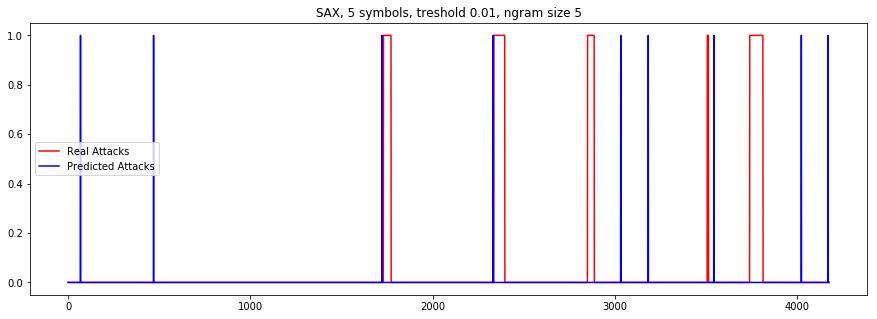

In [20]:
# F_PU1 and F_PU7 both detect other anomalies
training_data = data2.append(data, ignore_index = True)
test_data = data2
# features = ['L_T1', 'L_T4', 'L_T7', 'F_PU1', 'F_PU2', 'F_PU7', 'F_PU10', 'F_PU11']
# Training
# features = ['F_PU1', 'F_PU2', 'F_PU7', 'F_PU10', 'F_PU11']
# Test
# features = ['F_PU3', 'F_PU4', 'F_PU5', 'F_PU10','F_PU11']
# features = ['F_PU3']
features = training_data.columns
discretization(training_data, test_data, features,
               alphabet_size=5, 
               treshold=0.01, 
               n_elements_ngram=5,
               pp_treshold=3)

In [149]:
attack_ranges(data2['ATT_FLAG'])

[(1731, 1772), (2337, 2396), (2851, 2887), (3508, 3514), (3741, 3813)]


# PCA task

Perform PCA-based anomaly detection on the signal data. Set the threshold on training data to a value that results in few false positives on the training data. Plot the PCA residuals in one signal. Do you see large abnormalities in the training data? Can you explain why these occur? It is best to remove such abnormalities from the training data since you only want to model normal behavior. What kind of anomalies can you detect using PCA?

# Comparison task

Compare the performance of the PCA method with the ARMA and discrete models. Comparing anomaly detection methods in not straightforward, and different research studies frequently use different measures. You can either:
* test point-wise precision and recall, or
* overlap-based false and true positives, or /and
* count a true positive if it detects at least one anomaly in an anomalous region, or
* compare the top-k detected anomalies,
* or...

Describe in a few lines which comparison method you chose for this data and why. Keep in mind that
in practice an analyst has to take action on every positive detected, but will not study every detected
data point. Do you recommend using PCA, ARMA, or discrete models?

# Bonus task

Use PyTorch (or another framework) to learn Deep Neural Networks for anomaly detection as discussed in class and in the literature. Try out different learning rates and detection thresholds. Compare the performance with the three approaches tested above. Do you recommend using Deep Learning? Why (not)?

# Discretization Archive

In [ ]:
from tslearn.piecewise import SymbolicAggregateApproximation
from sklearn.preprocessing import StandardScaler
import pprint
import math


VALUE_FOR_ANOMALITY_DETECTED = 1
VALUE_FOR_NORMALITY_DETECTED = 0
MINIMAL_VALUE_FOR_ATTACK = 0.99


def create_markov_chain_from_ngram(levels, attack_data, n_elements):    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    attacks = zip(levels, attack_data)
    levels_to_use = []
    # Do not use the attacks in determining normal behaviour.
    for level, attack_value in attacks:
        if attack_value >= MINIMAL_VALUE_FOR_ATTACK:
            # Do not take into account attacks when training
            levels_to_use.append(None)
        else:
            levels_to_use.append(level)
    ngrams = list(zip(*[levels_to_use[i:] for i in range(n_elements)]))
#     print(ngrams)
    markov_chain = {}
    for ngram in ngrams:
        if not None in ngram:
            last_element = ngram[-1]
            ngram_base = ngram[:-1]
            if ngram_base not in markov_chain:
                markov_chain.update({ngram_base: {}})
            known_transitions = markov_chain[ngram_base]
            if last_element not in known_transitions:
                known_transitions.update({last_element: 1})
            else:
                known_transitions[last_element] += 1
    return markov_chain


def apply_smoothing_to_markov_chain(markov_chain, symbols):
    for d in markov_chain.values():
        links = d.keys()
        for s in symbols:
            if s not in links:
                d.update({s: 1})


def classify_using_markov_chains(sax_training, attacks_in_training, sax_test, symbols, treshold, n_elements):
    markov_chain = create_markov_chain_from_ngram(sax_training, attacks_in_training, n_elements)
    apply_smoothing_to_markov_chain(markov_chain, symbols)
    total_occurences = sum([sum(d.values()) for d in markov_chain.values()])
    normal_sequences = set()
    abnormal_sequences = set()
#     for ngram_base, last_elements in markov_chain.items():
#         ngram_occurences = sum([v for _, v in last_elements.items()])
#         for last_element, occurences in last_elements.items():
#             sequence_probability = occurences/ngram_occurences
#             t = list(ngram_base)
#             t.append(last_element)
#             if sequence_probability > treshold:
#                 normal_sequences.add(tuple(t))
#             else:
#                 abnormal_sequences.add(tuple(t))
    detected_list = []
#     print('Normal Sequences: ', normal_sequences)
#     print('Abnormal Sequences: ', abnormal_sequences)
    for i in range(len(sax_test)):
        if i >= len(sax_test) - n_elements:
            # Take the last n_elements values into account if 
            # we are at the end
            sequence = sax_test[-n_elements:]
        else:
            sequence = sax_test[i:i+n_elements]
        
        base = tuple(sequence[:-1])
        head = sequence[-1]
        
        if base not in markov_chain:
            markov_chain.update({base: {}})
        last_elements = markov_chain[base]
        # Apply some more smoothing.
        if head not in last_elements:
            last_elements.update({head: 1})
        base_occurences = sum(last_elements.values())
        occurences = last_elements[head]
        sequence_probability = occurences / base_occurences
        if sequence_probability < treshold or math.isclose(sequence_probability, treshold):            
#         if tuple(sequence) not in normal_sequences:
#             print(sequence)
            detected_list.append(VALUE_FOR_ANOMALITY_DETECTED)
        else:
            detected_list.append(VALUE_FOR_NORMALITY_DETECTED)
    return detected_list


def get_sax_data(training_data, test_data, n_segments, alphabet_size):
    # Scale data
    scaler = StandardScaler()
    preprocessed_training_data = training_data.values.reshape(-1,1)
    preprocessed_test_data = test_data.values.reshape(-1,1)
    scaled_training_data = scaler.fit_transform(preprocessed_training_data).ravel()
    # Only transform is called, because we want the same scale as the training data
    scaled_test_data = scaler.transform(preprocessed_test_data).ravel()
    
    #Perform SAX
    sax = SymbolicAggregateApproximation(n_segments=len(training_data), alphabet_size_avg=alphabet_size)
    # Compute SAX representations
    fit = sax.fit(scaled_training_data)
    transformed_training = fit.transform(scaled_training_data)
    # Compute time series corresponding to given SAX representations.
    ts_train = fit.inverse_transform(transformed_training)[0].ravel()
    
    # We cannot use the previous SAX, as then the creation of the alphabe is influenced by the test set 
    sax = SymbolicAggregateApproximation(n_segments=len(test_data), alphabet_size_avg=alphabet_size)
#     ts_test = []
#     for e in scaled_test_data:
#         transformation = fit.transform([e])
#         els = fit.inverse_transform(transformation)[0].ravel()
#         ts_e = sum(els)/len(els)
#         ts_test.append(ts_e)
# #         print(ts_e)
#     print(len(ts_test))
#     print(ts_test)
#     transformed_test = fit.transform(scaled_test_data)    
    transformed_test = sax.fit_transform(scaled_test_data)    
    ts_test = sax.inverse_transform(transformed_test)[0].ravel()
#     fr = len(ts_test)/len(test_data)
#     offset = round(fr*5)
#     offset = 1
    # We need to offset because of the used SAX transformation (bug)
#     res_test = [0]*offset
#     res_test = []
#     for i in range(len(test_data)):
#         res_test.append(ts_test[round(i*fr)])
#     return ts_train, res_test[:-offset]
    return ts_train, ts_test


def discretization(training_set, test_set, features, n_segments, alphabet_size, treshold, n_elements_ngram):
    attacks_in_training = training_set['ATT_FLAG']
    real_attacks = test_set['ATT_FLAG']
    
    for feature in features:         
        # Some configuration for the plots
        plt.figure(figsize=(15,5))
        axes=plt.gca() 
    
        # Calculate the Symbolic Aggregate approXimation
        sax_training, sax_test = get_sax_data(training_set[feature], test_set[feature], n_segments, alphabet_size) 
        symbols_training = set(sax_training)
        symbols_test = set(sax_test)
        symbols = symbols_training.union(symbols_test)
        if len(symbols) > alphabet_size:
            raise NotImplementedError("Too many symbols!")
        
        predicted_attacks = classify_using_markov_chains(sax_training, attacks_in_training, sax_test, symbols, 
                                                         treshold, n_elements_ngram)
        plt.plot(real_attacks,'r')
        plt.plot(predicted_attacks, 'b-')
#         plt.plot(sax_training, 'b-')
#         plt.plot(sax_test, 'r-')

        plot_title = f"SAX, {alphabet_size} symbols, {n_segments} segments, for {feature}"
        plt.legend(['Real Attacks', 'Predicted Attacks'])
        plt.title(plot_title)
        plt.show()
#             plt.savefig(plot_title)